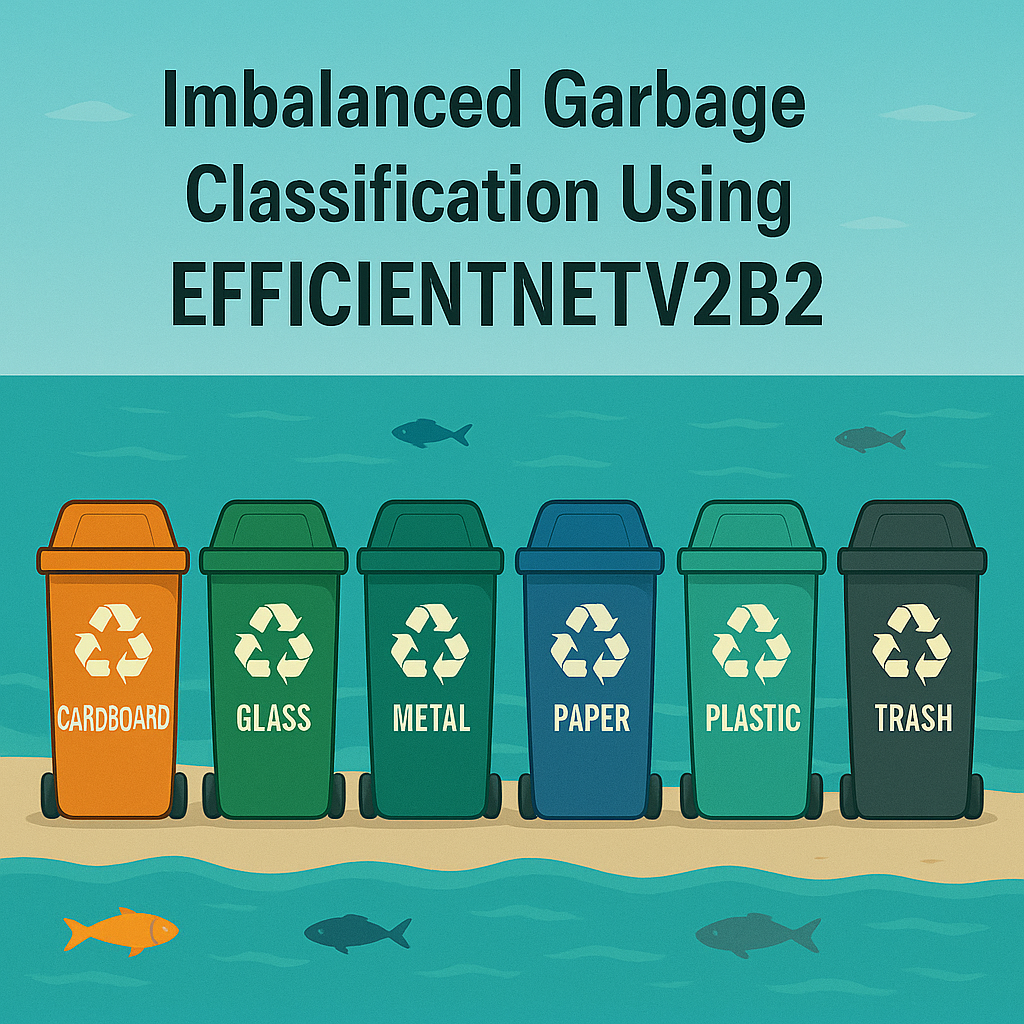

# **How Does It Work?**
1.Load a pretrained model (e.g., ResNet, EfficientNet).

2.Freeze the pretrained layers (optional).
3.Add new layers for your custom task.
4.Train on your new dataset (can also fine-tune).

**EfficientNetV2B2: Transfer Learning Backbone**

EfficientNetV2B2 is a mid-sized model from the EfficientNetV2 family developed by **Google**, balancing performance and efficiency.

**⚙️ Key Features:**

**Fused MBConv blocks —** enhance both training stability and speed.

**Progressive learning —** enables better generalization with less computation.

**Improved architecture** — achieves higher accuracy with optimized FLOPs.

### <span style="color:red"> Importing Libraries</span><br>

This section includes all essential libraries required for data preprocessing, visualization, model building, evaluation, and deployment.

1. **`os`** – for handling file paths, directories, and system-level operations  
2. **`numpy`** – for efficient numerical operations and array manipulations  
3. **`matplotlib.pyplot`** – for plotting graphs and visualizing training metrics  
4. **`seaborn`** – for enhanced statistical data visualizations (heatmaps, etc.)  
5. **`tensorflow`** – for building and training machine learning models  
6. **`keras`** – high-level API in TensorFlow used to simplify model architecture  
7. **`Sequential`** – to build models layer-by-layer in Keras  
8. **`layers`** – contains essential building blocks like Rescaling, Pooling, Dense, etc.  
9. **`optimizers` and `callbacks`** – for tuning model performance and training control  
10. **`Layer`** – for creating custom layers (if needed)  
11. **`EfficientNetV2B2`** – a pretrained model used for transfer learning  
12. **`compute_class_weight`** – handles class imbalance by computing weights  
13. **`confusion_matrix`, `classification_report`** – for model evaluation and diagnostics  
14. **`gradio`** – to build an interactive web interface for your trained model  

In [1]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

### <span style="color:red"> Loading Data</span><br>
The Dataset i have used is from Kaggle.com [**Garbage Image Dataset**](https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset) by Farzad Nekouei

- This program loads the dataset from a directory and automatically splits it into **training (80%)** and **validation (20%)** subsets using `image_dataset_from_directory`.
- The images are resized to **124×124** pixels and loaded in **batches of 32** for optimized memory and training performance.
- The validation dataset is further divided into two equal parts to create a **validation set** and a **test set**.
- Real-time performance optimization is applied to the test dataset using `cache()` and `prefetch()`.

**Libraries Used:** <br>
1. `tensorflow.keras.utils` : for loading and splitting datasets  
2. `tf.data` : for dataset cardinality, caching, and prefetching  

**Key Functions & Parameters:**  
1. `image_dataset_from_directory()` : loads image data with preprocessing and optional splitting  
2. `validation_split` : splits the dataset into training and validation subsets  
3. `subset="training"/"validation"` : indicates which split to load  
4. `image_size=(128, 128)` : resizes all images to the given size  
5. `batch_size=32` : defines how many images to load per batch  
6. `cardinality()` : gets number of batches to enable custom splitting  
7. `take()` / `skip()` : used to split validation dataset into validation and test sets  
8. `cache()` / `prefetch()` : boosts performance by preparing data ahead of time  


In [2]:
dataset_dir= r"/content/drive/MyDrive/TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [3]:
# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)


In [6]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


### <span style="color:red"> Visualizing the Dataset</span><br>

This program displays a 4×3 grid of **12 sample images** from the training dataset to visually verify correct preprocessing and labeling. It also includes better layout control and class labeling.

- **Libraries Used:** <br>
1. `matplotlib.pyplot` : for plotting and displaying images  
2. `numpy` : for converting tensors to NumPy arrays  

- **Functions Used:**  
1. `plt.figure()` : sets the overall figure size  
2. `plt.subplot()` : creates a subplot grid (4 rows × 3 columns)  
3. `plt.imshow()` : renders each image  
4. `plt.title()` : adds the corresponding class name and index as a title  
5. `plt.axis("off")` : hides axis ticks for clarity  
6. `plt.suptitle()` : adds an overall title to the figure  
7. `plt.tight_layout()` : optimizes spacing between subplots  
8. `plt.show()` : displays the final figure on screen

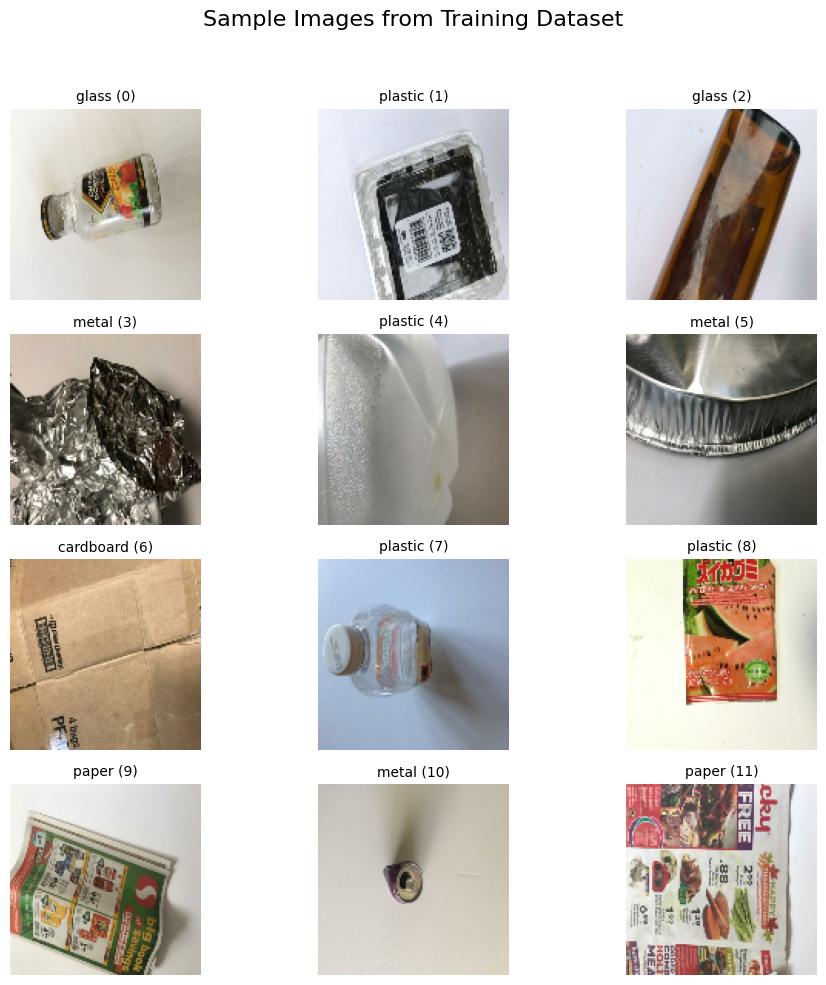

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    num_images = min(len(images), 12)
    for i in range(num_images):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{train_ds.class_names[labels[i]]} ({i})", fontsize=10)
        plt.axis("off")

plt.suptitle("Sample Images from Training Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust to make space for title
plt.show()

---

### <span style="color:red">Enhanced Class Distribution Visualization</span><br>

This program computes and displays the class-wise image distribution across the training, validation, and test datasets. It ensures the dataset is balanced enough for fair model training and evaluation.

- **Purpose:**  
  To calculate the percentage distribution of images per class and visualize the results to detect any imbalance that may affect model performance.

- **Steps Performed:**  
  1. `count_distribution()` function iterates through each dataset to count label occurrences and convert them into percentages.  
  2. `pandas.DataFrame` is used to display the class-wise percentages in a clean, tabular format.  
  3. `simple_bar_plot()` function uses `matplotlib` to visually represent the distribution for each dataset.  
  4. An `overall_dist` is computed by averaging training and validation distributions for a broader perspective.

- **Libraries Used:**  
  1. `pandas` – for formatting the output as a readable table  
  2. `matplotlib.pyplot` – for creating bar plots  
  3. `tensorflow` – for handling the image datasets  

- **Functions Used:**  
  - `count_distribution()` – counts and converts class occurrence to percentages  
  - `simple_bar_plot()` – creates bar charts with consistent styling  
  - `pd.DataFrame()` – organizes distribution data for display  
  - `to_string()` – prints the DataFrame cleanly without index  

> ✅ This step ensures your dataset is not only numerically balanced but also visually interpretable, helping you spot any class bias before training begins.



Class Distribution Summary:

    Class  Train (%)  Validation (%)  Test (%)  Overall (%)
cardboard      16.52           13.66     14.06        15.09
    glass      19.73           20.20     17.58        19.96
    metal      15.92           17.43     16.80        16.68
    paper      23.29           24.36     25.00        23.82
  plastic      19.44           17.62     19.14        18.53
    trash       5.09            6.73      7.42         5.91


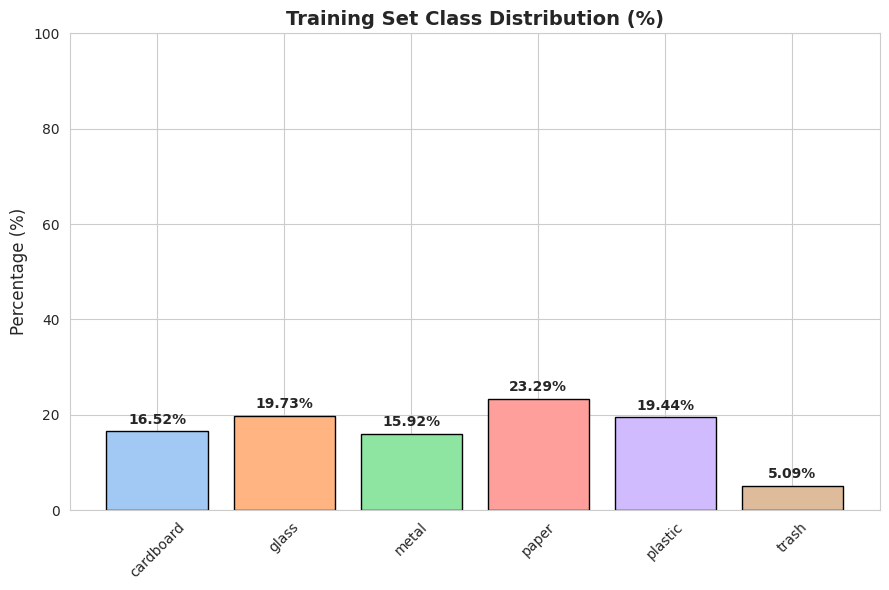

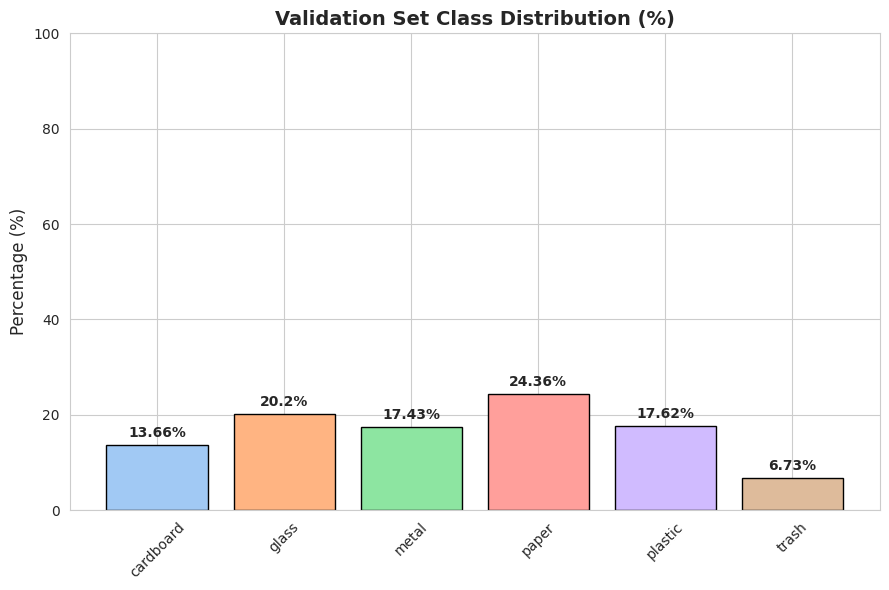

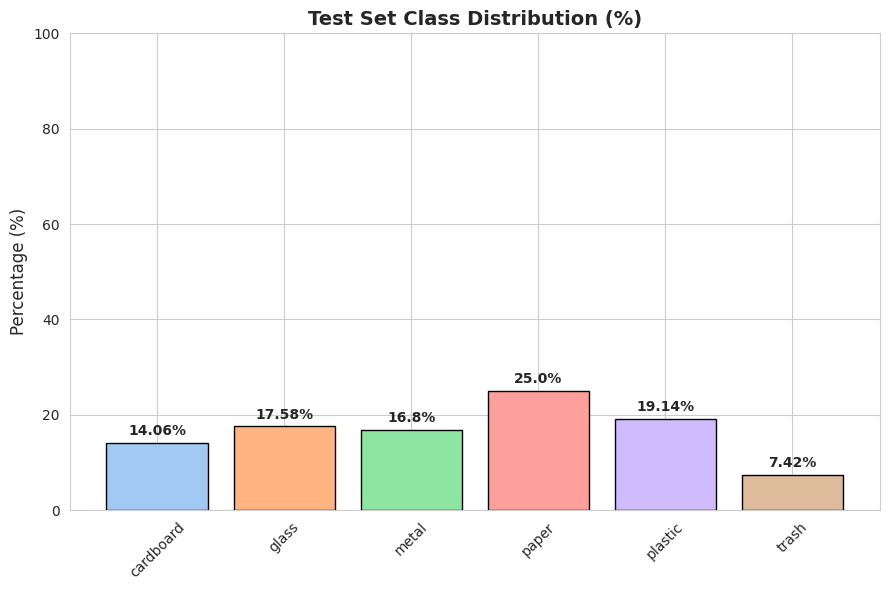

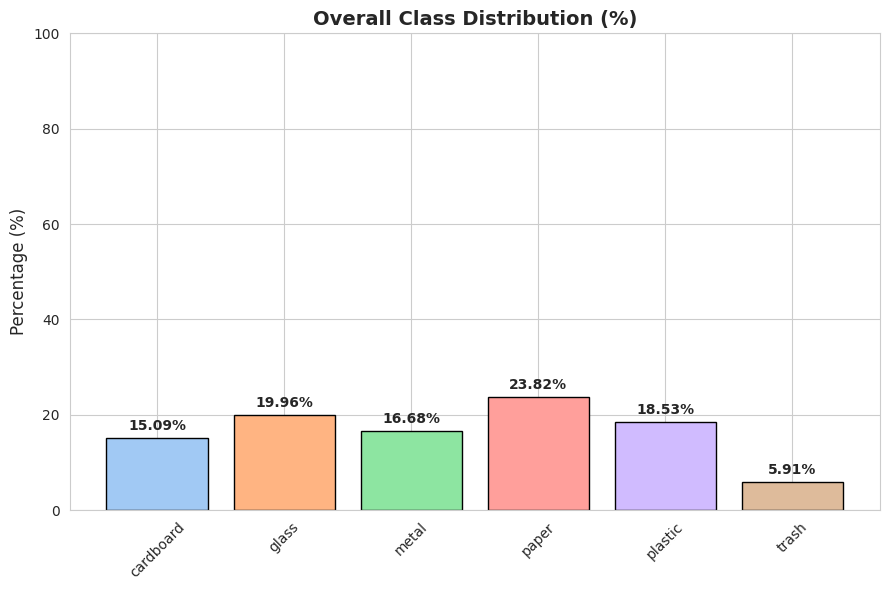

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Function to count class distribution (in %)
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            counts[class_names[label]] += 1
            total += 1

    return {k: round((v / total) * 100, 2) for k, v in counts.items()}

# Improved bar plot function with seaborn
def simple_bar_plot(dist, title):
    plt.figure(figsize=(9, 6))
    sns.set_style("whitegrid")

    bars = plt.bar(dist.keys(), dist.values(), color=sns.color_palette("pastel"), edgecolor='black')

    # Add value labels on top
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Get class names
class_names = train_ds.class_names

# Compute distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

# Create DataFrame
dist_df = pd.DataFrame({
    'Class': class_names,
    'Train (%)': [train_dist[k] for k in class_names],
    'Validation (%)': [val_dist[k] for k in class_names],
    'Test (%)': [test_dist[k] for k in class_names],
    'Overall (%)': [overall_dist[k] for k in class_names],
})

# Print clean table
print("\nClass Distribution Summary:\n")
print(dist_df.to_string(index=False))

# Plot distributions
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")



---

### <span style="color:red"> Calculating Class Weights to Handle Imbalance</span><br>

> This block handles imbalance in the dataset by assigning **weights** to each class based on its frequency in the training set. These weights will later help the model treat all classes fairly during training.

**Purpose:**  To compute class-wise weights so that underrepresented classes (like `trash`) are given more importance while training the model.

- **Steps Performed:**  
  1. **Loop through `train_ds`** to count the number of samples per class and collect all labels.
  2. Use **`compute_class_weight()`** to automatically calculate balanced class weights.
  3. Create a dictionary mapping class index to its weight.
  4. Display sample counts and computed weights with formatted output.

- **Libraries Used:**  
  1. `sklearn.utils.class_weight` – for calculating balanced weights  
  2. `numpy` – for label array handling and index alignment  

- **Functions Used:**  
  - `compute_class_weight()` – computes inverse-frequency weights  
  - `enumerate()` – used for mapping class indices  
  - `round()` – used to display weights with readable precision  

✅ These weights will be passed to `model.fit()` to help improve learning for rare classes and reduce prediction bias.


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Count class occurrences and collect all labels
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (balanced)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Map class index to weight
class_weights = {i: round(w, 4) for i, w in enumerate(class_weights_array)}

# ✨ Display results nicely
print("\n📊 Class Distribution in Training Set")
print("-" * 40)
for i, name in enumerate(class_names):
    print(f"{i}. {name:<10} ➤ Samples: {class_counts[i]:<4} | Weight: {class_weights[i]}")
print("-" * 40)
print(f"\n🧮 Total Training Samples: {sum(class_counts.values())}")




📊 Class Distribution in Training Set
----------------------------------------
0. cardboard  ➤ Samples: 334  | Weight: 1.009
1. glass      ➤ Samples: 399  | Weight: 0.8446
2. metal      ➤ Samples: 322  | Weight: 1.0466
3. paper      ➤ Samples: 471  | Weight: 0.7155
4. plastic    ➤ Samples: 393  | Weight: 0.8575
5. trash      ➤ Samples: 103  | Weight: 3.2718
----------------------------------------

🧮 Total Training Samples: 2022


---

### <span style="color:red"> Preprocessing and Model Training</span><br>


>This section outlines the complete training pipeline using **EfficientNetV2B2** as the backbone model, incorporating class imbalance handling, progress logging, and performance visualization.


#### Key Steps

1. **Data Augmentation** -
Applies real-time transformations to improve model generalization:

    - Horizontal flip
    - Random rotation
    - Random zoom
    - Random contrast

2. **Model Architecture** - A `Sequential` model with the following components:

    - **EfficientNetV2B2** (pretrained on ImageNet, `include_top=False`)
    - First **100 layers frozen** to preserve learned features
    - `GlobalAveragePooling2D` layer to reduce feature dimensions
    - `Dropout(0.3)` to reduce overfitting
    - Final `Dense(6, activation='softmax')` layer for 6-class prediction

3. **Loss & Optimizer**

    - Optimizer: `Adam` (with learning rate = 1e-4)
    - Loss Function: `sparse_categorical_crossentropy` (for integer labels)
    - Metrics: `accuracy`


4. **Callbacks Used**

    - `EarlyStopping`: Stops training if `val_loss` doesn't improve for 3 epochs  
    - `ModelCheckpoint`: Saves the best model (based on `val_accuracy`) to **`best_model.keras`**
    - `TqdmCallback`: Shows a live progress bar for each epoch in the terminal

5. **Training Settings**

    - Epochs: `15`
    - Batch Size: `32`
    - Uses `class_weights` to balance underrepresented classes
    - Trains on `train_ds`, validates on `val_ds`


6. **Post-training Outputs**

    - ✅ Saves the **best model** in `.keras` format  
    - ✅ Stores training history (`loss`, `accuracy`, etc.) in a **`.pkl` file** using `pickle`  
    - ✅ Displays a **Pandas table** of training metrics after training  
    - ✅ Plots **accuracy** and **loss** graphs for both training and validation over epochs



In [ ]:
# Unified Model Training Pipeline with 124x124 Image Input and Enhanced Output

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf
import pickle

# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Load Pretrained EfficientNetV2B2 with matching input size
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(124, 124, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build Final Model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model124.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Pre-training Summary
epochs = 10
print("\n📦 Starting Model Training...")
print(f"Epochs       : {epochs}")
print(f"Class Weights: {class_weights}")
print(f"Checkpoint   : Best model saved to 'best_model224.keras'")
print(f"Early Stop   : Enabled with patience=3\n")

# Train the Model with Tqdm progress bar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, checkpoint, TqdmCallback(verbose=1)]
)

# Display training log as a table
df_log = pd.DataFrame(history.history)
print("\n📊 Training Log Summary:")
print(df_log.to_string(index=True))

# Save history for later comparison
with open("history124.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



📦 Starting Model Training...
Epochs       : 10
Class Weights: {0: np.float64(1.009), 1: np.float64(0.8446), 2: np.float64(1.0466), 3: np.float64(0.7155), 4: np.float64(0.8575), 5: np.float64(3.2718)}
Checkpoint   : Best model saved to 'best_model224.keras'
Early Stop   : Enabled with patience=3



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3036 - loss: 1.7227
Epoch 1: val_accuracy improved from -inf to 0.61386, saving model to best_model124.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.3052 - loss: 1.7200 - val_accuracy: 0.6139 - val_loss: 1.1708
Epoch 2/10


In [11]:
# Find the base model layer by layer name or type
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnetv2b2" in layer.name.lower():
        base_model = layer
        break

# Print summary of the extracted base model
base_model.summary()



Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

### <span style="color:red">  Model Evaluation </span><br>

In [12]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 692ms/step - accuracy: 0.9220 - loss: 0.2723
Test accuracy is0.9141, Test loss is 0.2807


In [13]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step
[[26  0  0  2  0  0]
 [ 0 50  3  0  2  0]
 [ 0  0 42  0  1  1]
 [ 3  0  0 57  1  2]
 [ 0  2  1  0 43  1]
 [ 1  0  1  1  0 16]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        28
           1       0.96      0.91      0.93        55
           2       0.89      0.95      0.92        44
           3       0.95      0.90      0.93        63
           4       0.91      0.91      0.91        47
           5       0.80      0.84      0.82        19

    accuracy                           0.91       256
   macro avg       0.90      0.91      0.90       256
weighted avg       0.92      0.91      0.91       256



In [ ]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

### <span style="color:red"> Final Testing </span><br>

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


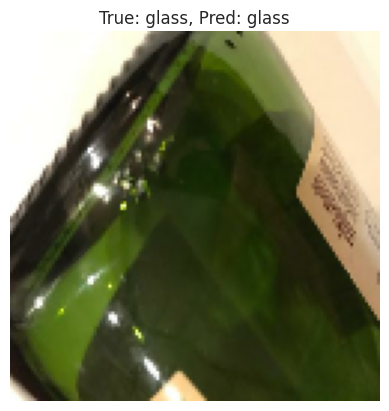

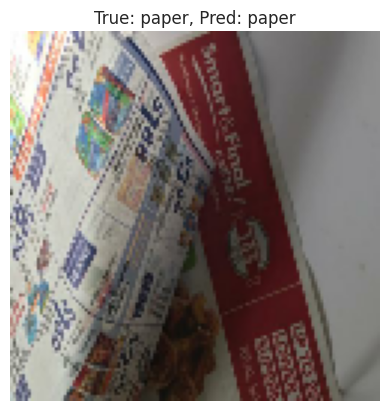

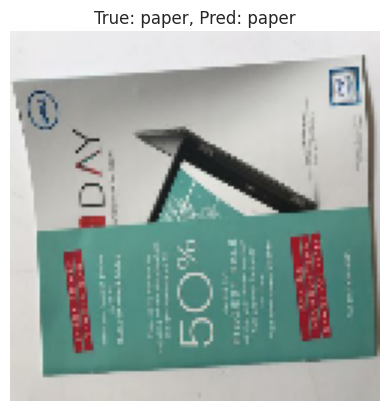

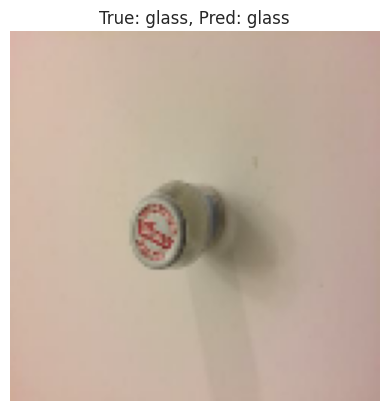

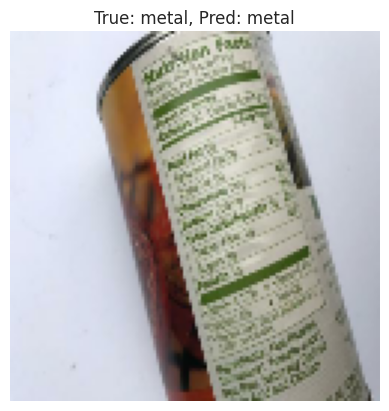

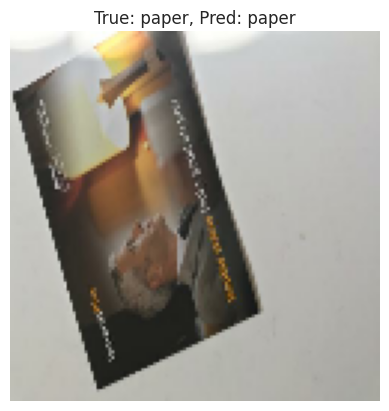

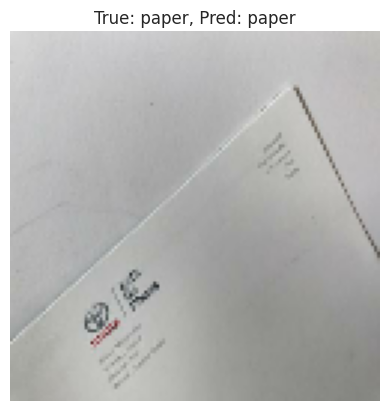

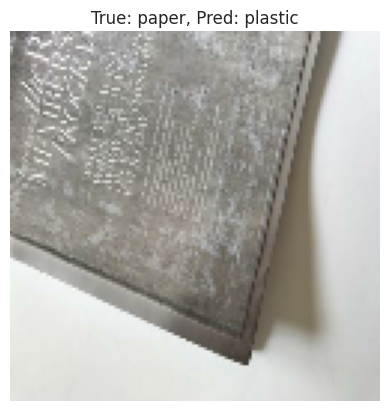

In [15]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

### 🌐 Gradio Interface and Preprocessing
- `gr`: To build a web interface for the model.
- `PIL.Image`: For handling image input in Gradio.
- `preprocess_input`: Preprocessing method for EfficientNet.
- `load_model`: For loading a saved model for inference.


In [17]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [ ]:
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [19]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://31bdef358d062a1ce7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
